# Import modules and parameters

In [5]:
!f2py3.10 -c -m fortran_integral models/fortran_integral.f90
!f2py3.10 -c -m fortran_quad models/fortran_quad.f90

running build
running config_cc
INFO: unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
INFO: unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
INFO: build_src
INFO: building extension "fortran_integral" sources
INFO: f2py options: []
INFO: f2py:> /tmp/tmpl57s9eqa/src.linux-x86_64-3.10/fortran_integralmodule.c
creating /tmp/tmpl57s9eqa/src.linux-x86_64-3.10
Reading fortran codes...
	Reading file 'models/fortran_integral.f90' (format:free)
Post-processing...
	Block: fortran_integral
{}
In: :fortran_integral:models/fortran_integral.f90:dgaus8:unknown_interface:f
vars2fortran: No typespec for argument "x_i_".
			Block: dgaus8
{}
In: :fortran_integral:models/fortran_integral.f90:dgaus8:unknown_interface:f
vars2fortran: No typespec for argument "x_i_".
					Block: f
Post-processing (stage 2)...
Building modules...
    Constructing call-back function "cb_f_in_dgaus8__user__routines"
appen

In [1]:
#!/usr/bin/pythonpy
################################################################################
# PYTHON's MODULAE
# test
# ------------------------------------------------------------------------------
################################################################################
import os
import sys
module_path = os.path.abspath(os.path.join('/lib/python3.10/site-packages'))
if module_path not in sys.path:
    sys.path.append(module_path)

import fortran_integral
import fortran_quad
import numpy as np
from numpy import sqrt as sqrt
from numpy import pi as pi

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.colorbar as colorb
import pickle 
import datetime
from matplotlib import colors

# Total cross sections
import models.sigma0_xsections as sig0
import models.general_parameters as gp
import models.relic_density_calc as ohm
import models.radiative_factorization as hp
import models.pdf_integration as qcd
import utils.colorb_2D as cb2d
import lhapdf  

#################################################
#today = datetime.date.today().strftime('%Y-%m-%d')
today = '2023-10-23'

## Some configurations
sigmaz = {}
## Geral parameters
brn = gp.brn

dmnames = sig0.dmnames
smax = gp.smax
me = gp.mvec[0]

Mmed = gp.Mmed  # TeV
mx  = gp.mx #  0.80 * Mmed/2  DM mass [TeV]
Nf_ee = gp.Nf_ee 
Nf_qq = gp.Nf_qq


---
---
# 1 - $e^{+}e^{-}$ interaction

## 1.1 Relic Density plot

In [2]:
### Larger values will increase the processing time
binsize_ohm = 70
Nfermions = 6
dM = 1/binsize_ohm 
dmx = 0.5/binsize_ohm 
#Mediator mass [Tev] # 
Mmed_min = 0.0001
Mmed_max = 5.1
Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)

# DM particle mass [Tev] #
mx_min = 0.0001
mx_max = 2.6
mx_arr = np.arange(mx_min, mx_max, dmx)
# Define a grid
Mmed_grid_ohm, mx_grid_ohm = np.meshgrid(Mmed_arr, mx_arr) # grid formation for plot
omegarelic_mass = {}

process = 'ee'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq
gr0 = gp.gr0_e if process == 'ee' else gp.gr0_q


for fignumber, dmname in enumerate(sig0.dmnames):

    print(f'Doing {dmname}')
    param_lst = [Mmed_grid_ohm**2, me, Mmed_grid_ohm, mx_grid_ohm, gr0, gr0, gp.gx0, dmname, Nf_x]
    omegarelic_mass[f'{dmname}'] = {}
    
    omegarelic_mass[f'{dmname}']['data'] = ohm.Ohm_numerical(Mmed_grid_ohm**2, me, Mmed_grid_ohm, mx_grid_ohm, gr0, gr0, gp.gx0, dmname, Nf_x)

    omegarelic_mass[f'{dmname}']['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))
    # saves the computed data for that DM scenario
    gp.save_obj(omegarelic_mass[f'{dmname}'], f'../myruns/{today}_omegarelic_mass_{process}_{dmname}_binsize_{binsize_ohm}.pkl')
    print(f'Done for {dmname}')

#gp.save_obj(omegarelic_mass, f'../myruns/{today}_omegarelic_mass_ee_{dmname}_binsize_{binsize_ohm}.pkl')

Doing Scalar
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_ee_Scalar_binsize_70.pkl
Done for Scalar
Doing Fermion
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_ee_Fermion_binsize_70.pkl
Done for Fermion
Doing Vector
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_ee_Vector_binsize_70.pkl
Done for Vector


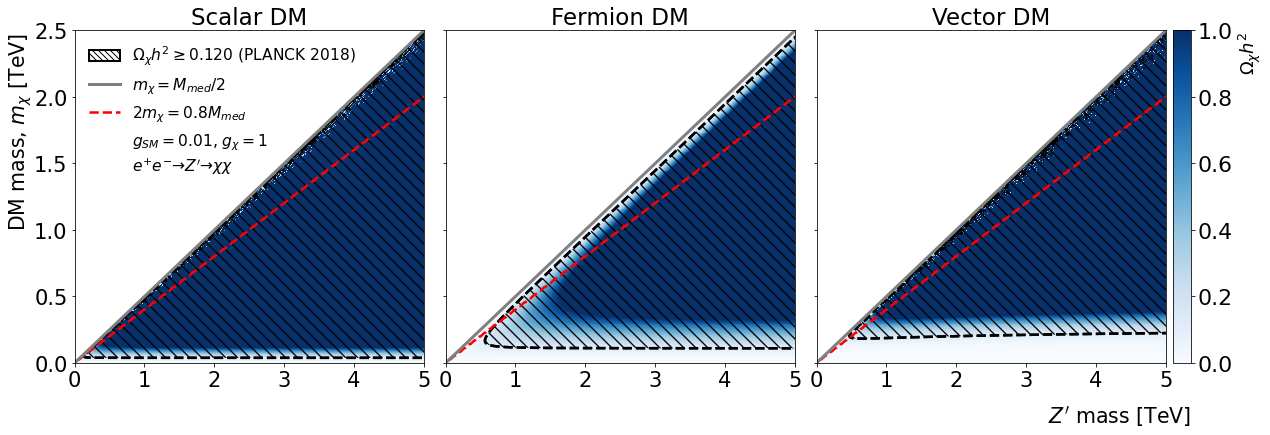

In [2]:
binsize_ohm = 70
process = 'ee'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq
gr0 = gp.gr0_e if process == 'ee' else gp.gr0_q
omegarelic_mass = {}
for dmname in sig0.dmnames:
    omegarelic_mass[dmname]  = gp.load_obj(f'../myruns/{today}_omegarelic_mass_{process}_{dmname}_binsize_{binsize_ohm}.pkl')

cb2d.cb_plot3x1_relic(process, f'5-omega-relic-{process}-mass', omegarelic_mass, sig0.dmnames,  gr0, folder = '../figures', today = today)

In [3]:
gr0

0.01

## 1.2 Mass x Mass plot

In [4]:
binsize = 100
dM = 1/binsize
dmx = 0.5/binsize
#Mediator mass [Tev] # 
Mmed_min = 0.001
Mmed_max = 5.1
Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)
# DM particle mass [Tev] #
mx_min = 0.001
mx_max = 2.60
mx_arr = np.arange(mx_min, mx_max, dmx)
# Define a grid
Mmed_grid, mx_grid = np.meshgrid(Mmed_arr, mx_arr) # grid formation for plot
## CM total energy (14 TeV for HL-LHC)
smax = (3)**2  

process = 'ee'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq
gr0 = gp.gr0_e if process == 'ee' else gp.gr0_q


sigmaz = {}
sighat_hphoton = {}
for fignumber, dmname in enumerate(sig0.dmnames):

    #define pdf
    print(f'Doing {dmname}')
    param_lst = [smax, me, Mmed_grid, mx_grid, gr0, gr0, gp.gx0, dmname, Nf_x]
    sigmaz[dmname] = {}

    sigmaz[f'{dmname}']['data'] = hp.HPhsig(smax, me, Mmed_grid, mx_grid, gr0, gr0, gp.gx0, sig0.SFV(dmname).sig0, Nf_x)
    sigmaz[f'{dmname}']['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))
    
    # Saves the file
    gp.save_obj(sigmaz[f'{dmname}'], f'../myruns/{today}_sigmaz_mass_{process}_{dmname}_binsize_{binsize}.pkl')



Doing Scalar
Objeto salvo em ../myruns/2023-10-23_sigmaz_mass_ee_Scalar_binsize_100.pkl
Doing Fermion
Objeto salvo em ../myruns/2023-10-23_sigmaz_mass_ee_Fermion_binsize_100.pkl
Doing Vector
Objeto salvo em ../myruns/2023-10-23_sigmaz_mass_ee_Vector_binsize_100.pkl


doing Scalar
doing Fermion
doing Vector


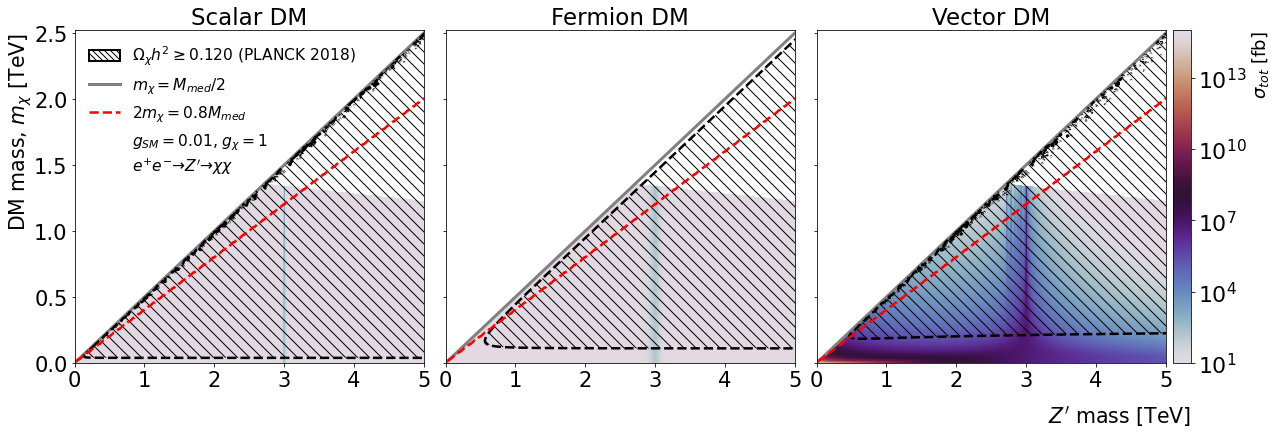

In [5]:

process = 'ee'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq
gr0 = gp.gr0_e if process == 'ee' else gp.gr0_q

binsize = 100
sigmaz = {}
for dmname in sig0.dmnames:
    sigmaz[dmname]  = gp.load_obj(f'../myruns/{today}_sigmaz_mass_{process}_{dmname}_binsize_{binsize}.pkl')

binsize_ohm = 70
omegarelic_mass = {}
for dmname in sig0.dmnames:
    omegarelic_mass[dmname]  = gp.load_obj(f'../myruns/{today}_omegarelic_mass_{process}_{dmname}_binsize_{binsize_ohm}.pkl')

cb2d.cb_plot3x1(process, f'10a-massxmass-{process}-ISR', sigmaz, omegarelic_mass, sig0.dmnames, gr0)

---
---
---

# 2 - $q \bar q$ interaction 


## 2.1 - Relic Density plot

### Data generation

In [7]:
### Larger values will increase the processing time
# omega_file = open(f'../myruns/omegarelic_mass_qq_bin{binsize}_nfermions{Nf_qq}.pkl', 'rb')
# omegarelic_mass_old = pickle.load(omega_file)
# omega_file.close()

binsize_ohm = 1
dM = 1/binsize_ohm 
dmx = 0.5/binsize_ohm 
#Mediator mass [Tev] # 
Mmed_min = 0.0001
Mmed_max = 101.1
Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)

# DM particle mass [Tev] #
mx_min = 0.0001
mx_max = 50.0
mx_arr = np.arange(mx_min, mx_max, dmx)

# Define a grid
Mmed_grid_ohm, mx_grid_ohm = np.meshgrid(Mmed_arr, mx_arr) # grid formation for plot

print('Doing mass x mass...')
omegarelic_mass = {}

process = 'qq'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq
gr0 = gp.gr0_e if process == 'ee' else gp.gr0_q

for fignumber, dmname in enumerate(sig0.dmnames):


    print(f'Doing {dmname}')
    param_lst = [Mmed_grid_ohm**2, gp.me, Mmed_grid_ohm, mx_grid_ohm, gr0, gr0, gp.gx0, dmname, Nf_x]
    omegarelic_mass[f'{dmname}'] = {}
    
    #if dmname == 'Vector':
    omegarelic_mass[f'{dmname}']['data'] = ohm.Ohm_numerical(Mmed_grid_ohm**2, gp.me, Mmed_grid_ohm, mx_grid_ohm, gr0, gr0, gp.gx0, dmname, Nf_x)
    #else: 
    #    omegarelic_mass[f'{dmname}']['data'] = omegarelic_mass_old[f'{dmname}']

    omegarelic_mass[f'{dmname}']['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))
    # saves the computed data for that DM scenario
    gp.save_obj(omegarelic_mass[f'{dmname}'], f'../myruns/{today}_omegarelic_mass_{process}_{dmname}_binsize_{binsize_ohm}.pkl')
    print(f'Done for {dmname}')

#gp.save_obj(omegarelic_mass, f'../myruns/{today}_omegarelic_mass_ee_{dmname}_binsize_{binsize_ohm}.pkl')

Doing mass x mass...
Doing Scalar
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_qq_Scalar_binsize_1.pkl
Done for Scalar
Doing Fermion
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_qq_Fermion_binsize_1.pkl
Done for Fermion
Doing Vector
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_qq_Vector_binsize_1.pkl
Done for Vector


### Plot

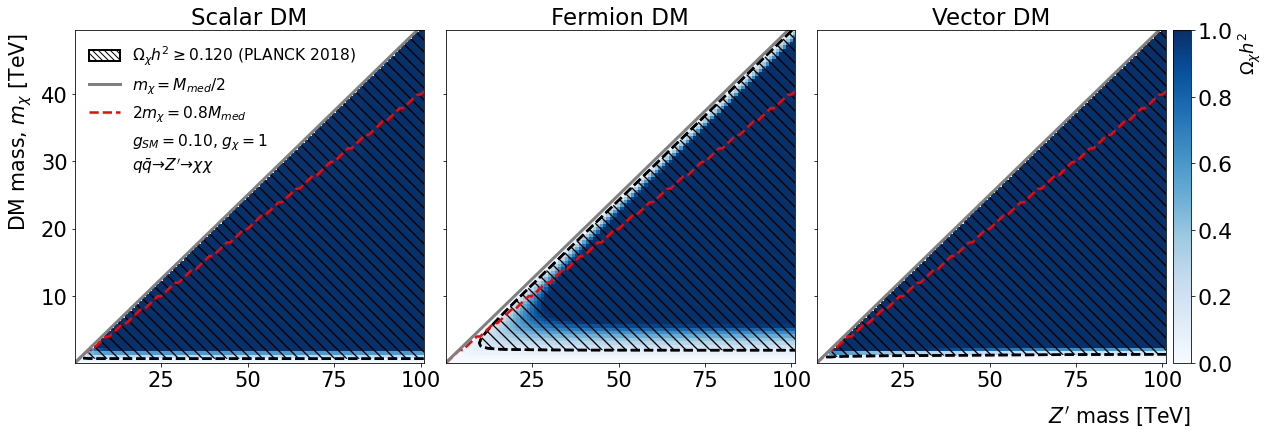

In [2]:
binsize_ohm = 1
process = 'qq'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq
gr0 = gp.gr0_e if process == 'ee' else gp.gr0_q


omegarelic_mass = {}
for dmname in sig0.dmnames:
    omegarelic_mass[dmname]  = gp.load_obj(f'../myruns/{today}_omegarelic_mass_{process}_{dmname}_binsize_{binsize_ohm}.pkl')


cb2d.cb_plot3x1_relic(process, f'6-omega-relic-{process}-mass' , omegarelic_mass, sig0.dmnames, gr0)

## 2.2 - XSEC plot

### Data generation

In [ ]:
binsize = 100
dM = 1/binsize
dmx = 0.5/binsize
#Mediator mass [Tev] # 
Mmed_min = 0.001
Mmed_max = 5.1
Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)
# DM particle mass [Tev] #
mx_min = 0.001
mx_max = 2.60
mx_arr = np.arange(mx_min, mx_max, dmx)
# Define a grid
Mmed_grid, mx_grid = np.meshgrid(Mmed_arr, mx_arr) # grid formation for plot
## CM total energy (14 TeV for HL-LHC)
s_max = (14)**2  

process = 'qq'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq
gr0 = gp.gr0_e if process == 'ee' else gp.gr0_q


## Recalculates... 
sigmaz = {}
sighat_hphoton = {}
for fignumber, dmname in enumerate(sig0.dmnames):

    #define pdf
    print(f'Doing {dmname}')
    PDF_sets = ['CT10', 'NNPDF31_lo_as_0118', 'CT18NLO', 'MMHT2014lo68cl', 'PDF4LHC15_nlo_100']
    pdf = lhapdf.mkPDF(PDF_sets[1], 0)
    param_lst = [Mmed_grid**2, me, Mmed_grid, mx_grid, gr0, gr0, gp.gx0, dmname, gp.Nf_qq]
    sigmaz[dmname] = {}

    sig0funcs = sig0.SFV(dmname).sig0
    sighat_hphoton[f'{dmname}'] = hp.HPhsig(Mmed_grid**2, me, Mmed_grid, mx_grid, gr0, gr0, gp.gx0, sig0funcs, gp.Nf_qq)

    sigmaz[f'{dmname}']['data'] = qcd.dsigdM2_ISR(pdf, s_max, (Mmed_grid)**2/s_max, Mmed_grid, 1, mx_grid, gr0, gr0, gp.gx0, sighat_hphoton[f'{dmname}'])
    sigmaz[f'{dmname}']['data'] = np.array(list(sigmaz[f'{dmname}']['data'][:, :]), dtype=np.float)

    sigmaz[f'{dmname}']['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))
    
    # Saves the file
    gp.save_obj(sigmaz[f'{dmname}'], f'../myruns/{today}_sigmaz_mass_{process}_{dmname}_binsize_{binsize}.pkl')



### Plot

doing Scalar
doing Fermion
doing Vector


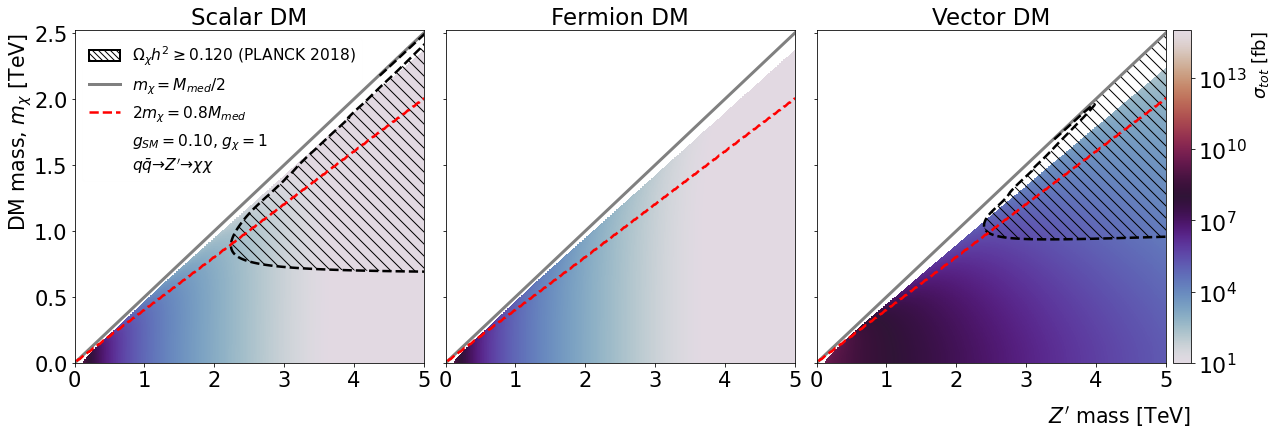

In [6]:
import utils.colorb_2D as cb2d
sigmaz = {}
binsize = 100
for dmname in sig0.dmnames:
    sigmaz[dmname]  = gp.load_obj(f'../myruns/{today}_sigmaz_mass_{process}_{dmname}_binsize_{binsize}.pkl')

binsize_ohm = 70
omegarelic_mass = {}
for dmname in sig0.dmnames:
    omegarelic_mass[dmname]  = gp.load_obj(f'../myruns/{today}_omegarelic_mass_{process}_{dmname}_binsize_{binsize_ohm}.pkl')

cb2d.cb_plot3x1(process, f'11-massxmass-{process}-ISR', sigmaz, omegarelic_mass, sig0.dmnames, gr0, cmap = 'twilight', fsize = 18, folder = '../figures')